<a href="https://colab.research.google.com/github/harrisuddin/F20DL/blob/main/F20DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [100]:
import sys
assert sys.version_info >= (3, 5)
# Python ≥3.5 is required


In [101]:
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

In [102]:
# Common imports
import numpy as np
import os
import tarfile
import urllib
import pandas as pd
import requests
import io
from sklearn.model_selection import train_test_split


In [103]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Get the data

In [104]:
raw_data_url = "https://raw.githubusercontent.com/harrisuddin/F20DL/main/Airbnb_Open_Data.csv"
def load_bnb_data(url=raw_data_url):
  # download the csv file from github
  download = requests.get(url).content

  # read the downloaded content and put into dataframe
  df = pd.read_csv(io.StringIO(download.decode("utf-8")),index_col=0,infer_datetime_format=True,dayfirst=False,dtype={'id':'int','instant_bookable':'string','cancellation_policy':'string','room type':'string','Construction year':'float','NAME':'string','host id':'int','host_identity_verified':'string' ,'host name':'string','neighbourhood group':'string','neighbourhood':'string','lat':'float','long':'float','country':'string','country code':'string', 	'...':'string','service fee':'string','minimum nights':'float','number of reviews':'float', 'last review':'object','reviews per month':'float','review rate number':'float','calculated host listings count':'float','availability 365':'float','house_rules':'string','license':'string'
})
  return df

In [105]:
bnb_data = load_bnb_data()

In [106]:
#Filters the bnb df to only contain values that makes sense in the context of a year such as availability and minimum nights as neither can go above 365 or below 0
bnb_data=bnb_data[(bnb_data['availability 365']>=0)&(bnb_data['availability 365']<=365)&(bnb_data['minimum nights']<=365)&(bnb_data['minimum nights']>=0)]


In [107]:
#This method prints information about a DataFrame including the dtype and columns, non-null values and memory usage.
#changing the 2 prices to ints for better analysis
bnb_data[bnb_data.columns[14]] = bnb_data[bnb_data.columns[14]].replace('[\$,]', '', regex=True).astype(float)
bnb_data[bnb_data.columns[15]] = bnb_data[bnb_data.columns[15]].replace('[\$,]', '', regex=True).astype(float)
bnb_data[bnb_data.columns[16]] = bnb_data[bnb_data.columns[16]].replace('[\$,]', '', regex=True).astype(float)

bnb_data['host_identity_verified']=bnb_data['host_identity_verified'].fillna('unconfirmed')
bnb_data['country']=bnb_data['country'].fillna('United States')
bnb_data['country code']=bnb_data['country code'].fillna('US')
bnb_data['instant_bookable']=bnb_data['instant_bookable'].fillna('FALSE')
bnb_data['cancellation_policy']=bnb_data['cancellation_policy'].fillna('strict')
bnb_data['room type']=bnb_data['room type'].fillna('Entire home/apt') #filling in with most common entry
bnb_data['price']=bnb_data['price'].fillna(np.mean(bnb_data['price']))
bnb_data['service fee']=bnb_data['service fee'].fillna(np.mean(bnb_data['service fee'])) #filling in with mean of service fee
bnb_data['minimum nights']=bnb_data['minimum nights'].fillna(np.mean(bnb_data['minimum nights']))
bnb_data['number of reviews']=bnb_data['number of reviews'].fillna(0)
bnb_data['reviews per month']=bnb_data['reviews per month'].fillna(0)
bnb_data['review rate number']=bnb_data['review rate number'].fillna(0)
bnb_data['availability 365']=bnb_data['availability 365'].fillna(np.mean(bnb_data['availability 365']))
bnb_data['house_rules']=bnb_data['house_rules'].fillna('unspecified')
bnb_data['license']=bnb_data['license'].fillna('unspecified')

bnb_data.info() 
#bnb_data.describe()
#Q2 Can you tell if there are any missing values? If yes, which attributes contain missing values ? 
#bnb_data.info() is used to find how many instances have missing values by comparing entry count and Non-Null values 
#most incomplete attribute is license, house rules, reviews per month and review rate number. 
#However in this case a null value could mean no reviews were done rather than the data being missing

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98527 entries, 1001254 to 6094647
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   NAME                            98312 non-null  string 
 1   host id                         98527 non-null  int64  
 2   host_identity_verified          98527 non-null  string 
 3   host name                       98141 non-null  string 
 4   neighbourhood group             98511 non-null  string 
 5   neighbourhood                   98515 non-null  string 
 6   lat                             98519 non-null  float64
 7   long                            98519 non-null  float64
 8   country                         98527 non-null  string 
 9   country code                    98527 non-null  string 
 10  instant_bookable                98527 non-null  string 
 11  cancellation_policy             98527 non-null  string 
 12  room type               

In [108]:
bnb_data.head()

,NAME,host id,host_identity_verified,host name,neighbourhood group,neighbourhood,lat,long,country,country code,...,service fee,minimum nights,number of reviews,last review,reviews per month,review rate number,calculated host listings count,availability 365,house_rules,license
id,,,,,,,,,,,,,,,,,,,,,
1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,United States,US,...,193.0,10.0,9.0,10/19/2021,0.21,4.0,6.0,286.0,Clean up and treat the home the way you'd like...,unspecified
1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,United States,US,...,28.0,30.0,45.0,5/21/2022,0.38,4.0,2.0,228.0,Pet friendly but please confirm with me if the...,unspecified
1002403,THE VILLAGE OF HARLEM....NEW YORK !,78829239556,unconfirmed,Elise,Manhattan,Harlem,40.80902,-73.94190,United States,US,...,124.0,3.0,0.0,NaN,0.00,5.0,1.0,352.0,"I encourage you to use my kitchen, cooking and...",unspecified
1002755,<NA>,85098326012,unconfirmed,Garry,Brooklyn,Clinton Hill,40.68514,-73.95976,United States,US,...,74.0,30.0,270.0,7/5/2019,4.64,4.0,1.0,322.0,unspecified,unspecified
1003689,Entire Apt: Spacious Studio/Loft by central park,92037596077,verified,Lyndon,Manhattan,East Harlem,40.79851,-73.94399,United States,US,...,41.0,10.0,9.0,11/19/2018,0.10,3.0,1.0,289.0,"Please no smoking in the house, porch or on th...",unspecified


In [109]:
bnb_data["lat"].value_counts()
# Q3 What does the value_count() method display?
# Returns the count of unique values in the dataset

40.76411    36
40.71813    31
40.76125    28
40.73756    27
40.76106    25
            ..
40.62598     1
40.77674     1
40.73647     1
40.82856     1
40.78423     1
Name: lat, Length: 21748, dtype: int64

In [110]:
# This method shows a statistical summary of the numerical attributes 
bnb_data.describe() 

,host id,lat,long,Construction year,price,service fee,minimum nights,number of reviews,reviews per month,review rate number,calculated host listings count,availability 365
count,9.852700e+04,98519.000000,98519.000000,98361.000000,98527.000000,98527.000000,98527.000000,98527.000000,98527.000000,98527.000000,98237.000000,98527.000000
mean,4.923672e+10,40.727974,-73.949330,2012.489767,625.789851,125.129303,7.886001,27.117450,1.177504,3.278076,8.058624,134.460737
std,2.854289e+10,0.055977,0.049888,5.764003,331.324105,66.248412,17.056816,48.837168,1.691388,1.289284,32.631483,129.802427
min,1.236005e+08,40.499790,-74.249840,2003.000000,50.000000,10.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,2.455850e+10,40.688690,-73.982520,2008.000000,341.000000,68.000000,2.000000,1.000000,0.090000,2.000000,1.000000,2.000000
50%,4.910042e+10,40.722160,-73.954320,2012.000000,625.789851,125.000000,3.000000,7.000000,0.490000,3.000000,1.000000,90.000000
75%,7.396972e+10,40.762680,-73.931900,2018.000000,913.000000,183.000000,5.000000,30.000000,1.740000,4.000000,2.000000,254.000000
max,9.876313e+10,40.916970,-73.705220,2022.000000,1200.000000,240.000000,365.000000,1024.000000,90.000000,5.000000,332.000000,365.000000


The count, mean, min, and max rows are self-explanatory. Note that the null values are ignored.

The 25%, 50%, and 75% rows show the corresponding percentiles: a percentile indicates the value below which a given percentage of observations in a group of observations fall.

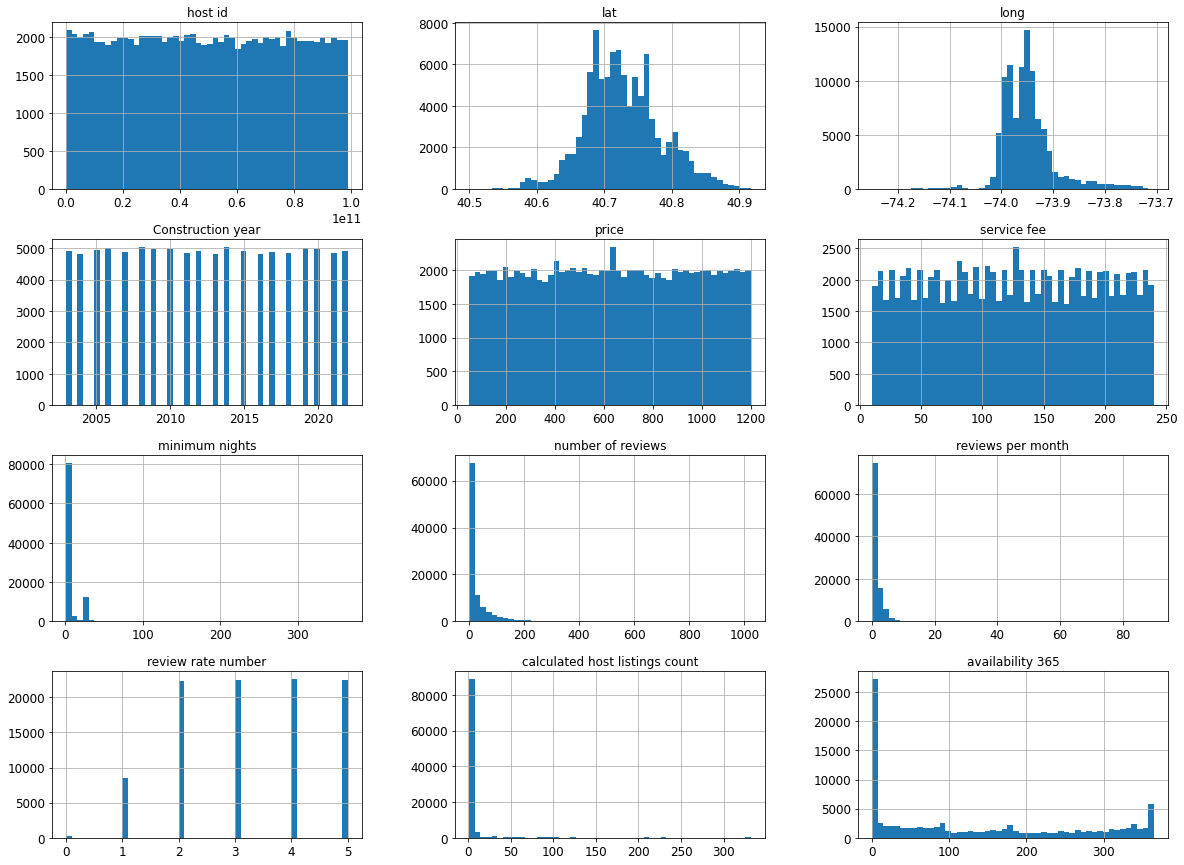

In [111]:
# To plot a histogram for each numerical attribute
bnb_data.hist(bins=50, figsize=(20,15))
plt.show()
# Q4 List down the main observations you noted from the statistical summary and the histogram

#- host id is pointless to show like this
#- This is also true for some of the data statistics in such as construction year's std and mean do not provide a lot of insight or meaning
#- Max availability is 3677 which cannot be true in a 365 day/year same can be said for minimum nights at >365 or <0(before removing those values in line 11)
#- an near-equal number of 2, 3, 4, 5 star reviews which is annoying
#- same with construction year

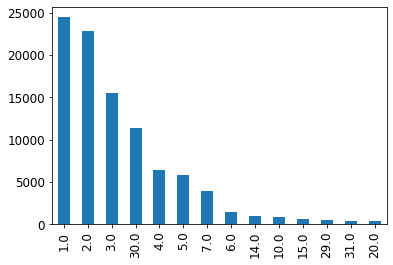

In [112]:
# Q5 Now you will plot 3 different variations of the data, which one is more indicative and why?

# plotting the frequency of minimum required overnight stays per property
bnb_data['minimum nights'].value_counts()[:20].plot.bar()

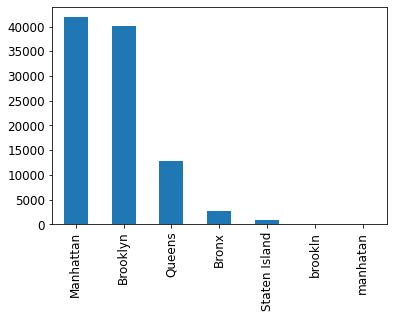

In [113]:
# plotting the frequency of property neighbourhoods
bnb_data['neighbourhood group'].value_counts()[:20].plot.bar()

# those like 5 or so undercapitalised ones lol
# includes typos

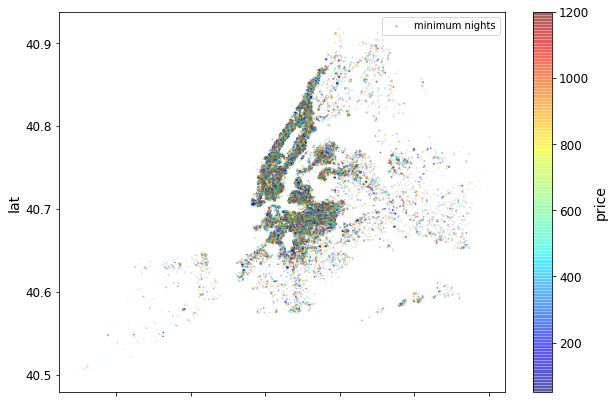

In [114]:
bnb_data.plot(kind="scatter", x="long", y="lat", alpha=0.4,
    s=bnb_data["minimum nights"]/100, label="minimum nights", figsize=(10,7),
    c="price", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()
#EXAMPLE plots California housing prices:red is expensive, blue is cheap. Large circles indicate areas with larger populations.
#EXAMPLE The radius of each circle represents the district’s population(option s) and the color represents the price (option c).
# plots the price of a property against its longitude and latitude 

In [115]:
# Now we will look at the correlation of all the attributes with the expected class attribute (median-house-value)
corr_matrix = bnb_data.corr() # computes the standard correlation coefficient (Pearson’s r) between every pair of attributes

In [116]:
corr_matrix["price"].sort_values(ascending=False)
# Q6 Which are the most correlated attributes with the output variable(i.e.median house value)?
# Does that make sense? 

price                             1.000000
service fee                       0.997834
number of reviews                 0.005935
reviews per month                 0.005707
host id                           0.003555
long                              0.001548
calculated host listings count   -0.000598
availability 365                 -0.002108
Construction year                -0.004528
lat                              -0.005696
review rate number               -0.005795
minimum nights                   -0.005983
Name: price, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff01dc81ed0>,
      dtype=object)

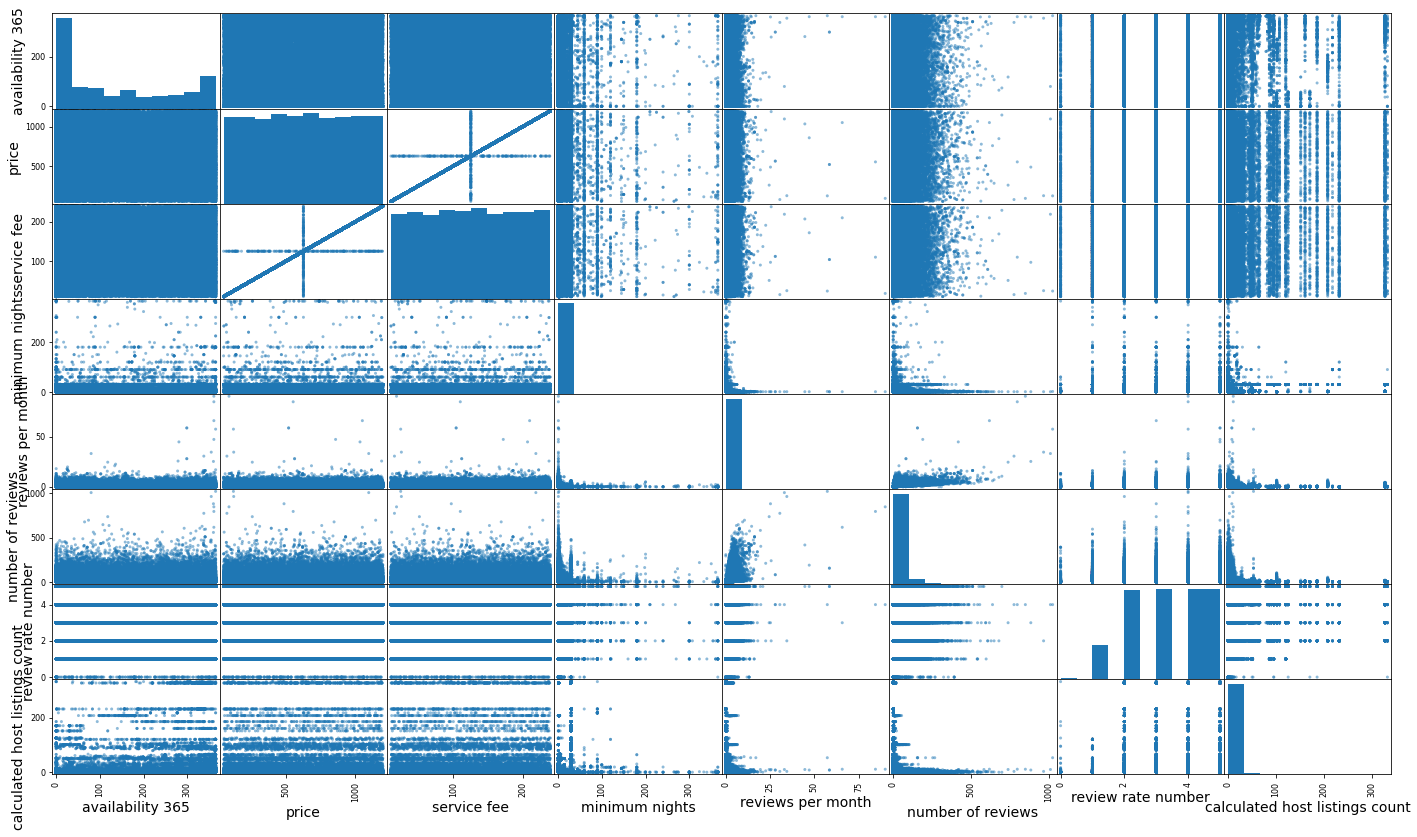

In [117]:
from pandas.plotting import scatter_matrix

attributes = ["availability 365","price", "service fee",'minimum nights',
              'reviews per month','number of reviews',
              'review rate number','calculated host listings count']
scatter_matrix(bnb_data[attributes], figsize=(24, 14))
# Another way to check for correlation between attributes is to use the pandas scatter_matrix() function above
# Here we choose to plot 4 promising  numerical attributes against each other

(0.0, 1250.0, 0.0, 275.0)

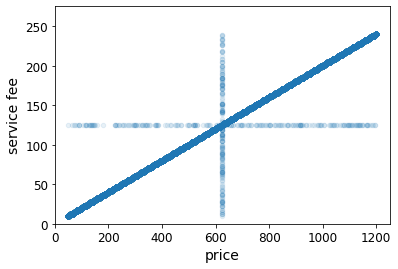

In [118]:
# let’s zoom in on the correlation scatterplot "median house value & the median income,"
bnb_data.plot(kind="scatter", x="price", y="service fee",
             alpha=0.1)
plt.axis([0, 1250, 0, 275])
#Q7 Describe the plot below. What does this indicate? Do you have an explanation for the solid line?
#theres a direct correlation between a bnb's price and its service fee
#bnb's price may include the service fee as a sum

# Experimenting with Attribute Combinations

In [119]:
# Here you will generate new features. This is what we call feature engineering
# Q8 What are the new features that you are generating? Do they make sense ?

bnb_data["minimum stay cost per night"] = bnb_data["price"]/bnb_data["minimum nights"]
#others are from the example

#bnb_data["bedrooms_per_room"] = bnb_data["total_bedrooms"]/bnb_data["total_rooms"]
#bnb_data["population_per_household"]=bnb_data["population"]/bnb_data["households"]

In [120]:
corr_matrix = bnb_data.corr()
corr_matrix["minimum stay cost per night"].sort_values(ascending=False)
# Now you are checking the correlations given the new features 
# Q9 Did you get better features ?

minimum stay cost per night       1.000000
price                             0.529871
service fee                       0.528872
reviews per month                 0.224972
number of reviews                 0.112483
long                              0.094758
Construction year                 0.004410
host id                           0.001699
review rate number               -0.004833
lat                              -0.010376
availability 365                 -0.012369
calculated host listings count   -0.100044
minimum nights                   -0.334932
Name: minimum stay cost per night, dtype: float64

In [121]:
#Q10 Plot the scatter plot of the rooms_per_household against median_house_value
#Q11 Now use the housing describe method to view the statistical summary of the dataset 

In [122]:
# y = bnb_data["price"]
# y = y.dropna(how='any',axis=0)
X = bnb_data.select_dtypes(include=['float64'])
X = X.dropna(how='any',axis=0)
y = X["price"]
X = X.drop(columns=["price", "minimum stay cost per night"])
X.describe()

,lat,long,Construction year,service fee,minimum nights,number of reviews,reviews per month,review rate number,calculated host listings count,availability 365
count,98067.000000,98067.000000,98067.000000,98067.000000,98067.000000,98067.000000,98067.000000,98067.000000,98067.000000,98067.000000
mean,40.727966,-73.949324,2012.490114,125.138702,7.893450,27.063406,1.177419,3.281552,8.067189,134.437425
std,0.055959,0.049925,5.762923,66.245045,17.047806,48.786374,1.692493,1.286285,32.656941,129.831508
min,40.499790,-74.249840,2003.000000,10.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,40.688690,-73.982530,2008.000000,68.000000,2.000000,1.000000,0.090000,2.000000,1.000000,2.000000
50%,40.722170,-73.954320,2012.000000,125.000000,3.000000,7.000000,0.490000,3.000000,1.000000,90.000000
75%,40.762660,-73.931870,2017.000000,183.000000,5.000000,30.000000,1.740000,4.000000,2.000000,254.000000
max,40.916970,-73.705220,2022.000000,240.000000,365.000000,1024.000000,90.000000,5.000000,332.000000,365.000000


In [123]:
from sklearn.linear_model import SGDClassifier, SGDRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
y_train_above_mean = (y_train > 626.110441)
y_test_above_mean = (y_test > 626.110441)
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_above_mean)

SGDClassifier(random_state=42)

In [124]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_above_mean, cv=3)

<img src="https://miro.medium.com/max/1051/1*fxiTNIgOyvAombPJx5KGeA.png" alt="Confusion Matrix" style="width: 400px;"/>

In [125]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_above_mean, y_train_pred)

array([[23183,  1387],
       [   68, 24395]])

In [126]:
y_train_perfect_predictions = y_train_above_mean  # pretend we reached perfection
confusion_matrix(y_train_above_mean, y_train_perfect_predictions)

array([[24570,     0],
       [    0, 24463]])

In [127]:
from sklearn.metrics import precision_score, recall_score

# Precision is the number of correctly classified positive examples divided by the total number of examples that are classified as positive. 
precision_score(y_train_above_mean, y_train_pred)

0.9462027771313319

In [128]:
# Recall r is the number of correctly classified positive examples divided by the total number of actual positive examples in the test set. 
recall_score(y_train_above_mean, y_train_pred)

0.9972202918693537

In [129]:
from sklearn.metrics import f1_score
# f1 score (or f-measure) combines the recall and precision, the higher the better the model
f1_score(y_train_above_mean, y_train_pred)

0.9710418947158921

In [130]:
y_scores = sgd_clf.decision_function(X_train.iloc[[1]])
y_scores

array([86677.68326969])

In [131]:
threshold = 0
y_some_row_pred = (y_scores > threshold)

In [132]:
y_some_row_pred

array([ True])

In [133]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [134]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_above_mean, cv=3,
                             method="decision_function")

In [135]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_above_mean, y_scores)

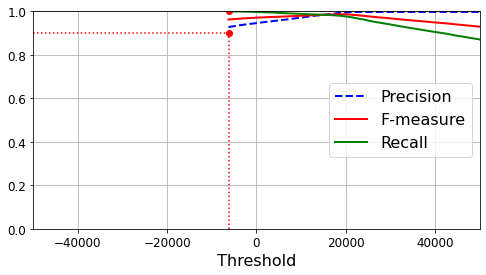

In [136]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, (2*recalls[:-1]*precisions[:-1])/(recalls[:-1]+precisions[:-1]), "r-", label="F-measure", linewidth=2) #F-measure
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
plt.show()

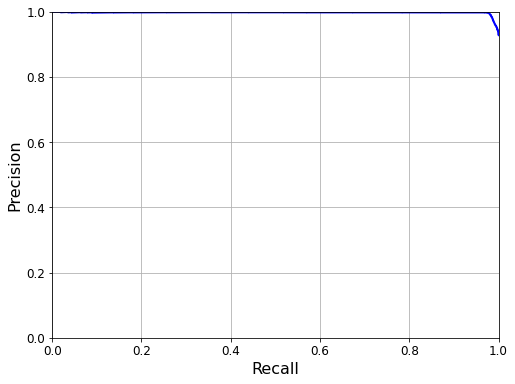

In [137]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
# plt.plot([0.4368, 0.4368], [0., 0.9], "r:")
# plt.plot([0.0, 0.4368], [0.9, 0.9], "r:")
# plt.plot([0.4368], [0.9], "ro")
plt.show()

In [138]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_above_mean, y_scores)

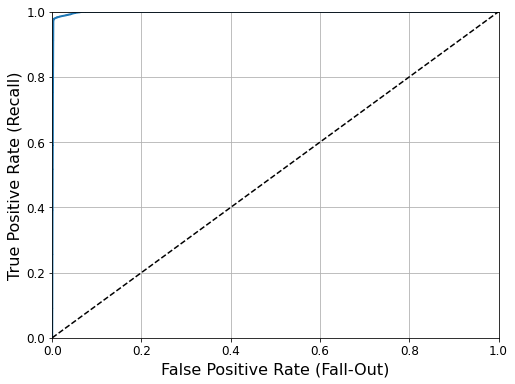

In [139]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
# plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
# plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
# plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

In [140]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_above_mean, y_scores)

0.9981844642372788

In [141]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_above_mean, cv=3, scoring="accuracy")

array([0.99431019, 0.95558003, 0.96108664])

In [142]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

X = bnb_data.select_dtypes(include=['float64'])
X = X.dropna(how='any',axis=0)
y = X["price"]
X = X.drop(columns=["price", "minimum stay cost per night"])

x_trainTTS, x_testTTS, y_trainTTS, y_testTTS = train_test_split(X, y, test_size=0.5)

y_trainTTS_above_mean = (y_trainTTS > 625.830539)
y_testTTS_above_mean = (y_testTTS > 625.830539)

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)

sgd_clf.fit(x_trainTTS, y_trainTTS_above_mean)

score = sgd_clf.score(x_trainTTS, y_trainTTS_above_mean)
print("Training score: ", score) 


Training score:  0.9663287989721208


as can be seen from the 2 codeblocks above the cross validation gives a much higher accuracy score than test/train split also more importantly i would argue the cross validation runs much faster than the test train split.

# Pipeline stuff

In [143]:
bnb_data.describe()

,host id,lat,long,Construction year,price,service fee,minimum nights,number of reviews,reviews per month,review rate number,calculated host listings count,availability 365,minimum stay cost per night
count,9.852700e+04,98519.000000,98519.000000,98361.000000,98527.000000,98527.000000,98527.000000,98527.000000,98527.000000,98527.000000,98237.000000,98527.000000,98527.000000
mean,4.923672e+10,40.727974,-73.949330,2012.489767,625.789851,125.129303,7.886001,27.117450,1.177504,3.278076,8.058624,134.460737,288.493563
std,2.854289e+10,0.055977,0.049888,5.764003,331.324105,66.248412,17.056816,48.837168,1.691388,1.289284,32.631483,129.802427,288.696453
min,1.236005e+08,40.499790,-74.249840,2003.000000,50.000000,10.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.196226
25%,2.455850e+10,40.688690,-73.982520,2008.000000,341.000000,68.000000,2.000000,1.000000,0.090000,2.000000,1.000000,2.000000,62.250000
50%,4.910042e+10,40.722160,-73.954320,2012.000000,625.789851,125.000000,3.000000,7.000000,0.490000,3.000000,1.000000,90.000000,196.600000
75%,7.396972e+10,40.762680,-73.931900,2018.000000,913.000000,183.000000,5.000000,30.000000,1.740000,4.000000,2.000000,254.000000,408.000000
max,9.876313e+10,40.916970,-73.705220,2022.000000,1200.000000,240.000000,365.000000,1024.000000,90.000000,5.000000,332.000000,365.000000,1200.000000


In [144]:
np.random.seed(42)

In [145]:
def split_train_test(data, test_ratio):
  shuffled_indices = np.random.permutation(len(data))
  test_set_size = int(len(data) * test_ratio) 
  test_indices = shuffled_indices[:test_set_size]
  train_indices = shuffled_indices[test_set_size:]
  return data.iloc[train_indices], data.iloc[test_indices]

In [146]:
train_set, test_set = split_train_test(bnb_data, 0.2)
len(train_set), len(test_set)

(78822, 19705)

In [147]:
bnb_num = bnb_data.select_dtypes(include=['float64'])
bnb_num.head()

,lat,long,Construction year,price,service fee,minimum nights,number of reviews,reviews per month,review rate number,calculated host listings count,availability 365,minimum stay cost per night
id,,,,,,,,,,,,
1001254,40.64749,-73.97237,2020.0,966.0,193.0,10.0,9.0,0.21,4.0,6.0,286.0,96.600000
1002102,40.75362,-73.98377,2007.0,142.0,28.0,30.0,45.0,0.38,4.0,2.0,228.0,4.733333
1002403,40.80902,-73.94190,2005.0,620.0,124.0,3.0,0.0,0.00,5.0,1.0,352.0,206.666667
1002755,40.68514,-73.95976,2005.0,368.0,74.0,30.0,270.0,4.64,4.0,1.0,322.0,12.266667
1003689,40.79851,-73.94399,2009.0,204.0,41.0,10.0,9.0,0.10,3.0,1.0,289.0,20.400000


In [148]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")), # Dealing with missing values
    #('attribs_adder', CombinedAttributesAdder()), # New attribute
    ('std_scaler', StandardScaler()),            # Attribute normalization
])

bnb_num_tr = num_pipeline.fit_transform(bnb_num)
bnb_num_tr

array([[-1.43787142, -0.46184399,  1.30419536, ..., -0.06253847,
         1.16746686, -0.66469309],
       [ 0.45818534, -0.69036448, -0.95308184, ..., -0.18529245,
         0.72063166, -0.98290667],
       [ 1.44792947,  0.14894717, -1.30035525, ..., -0.21598094,
         1.67593451, -0.28343719],
       ...,
       [-0.34575845,  0.05653669, -1.64762867, ..., -0.21598094,
         0.7129276 ,  1.92419841],
       [-0.94550051, -0.6238129 , -0.60580842, ..., -0.21598094,
         1.59889396,  0.14146339],
       [ 0.71634062, -0.6833485 , -0.43217171, ..., -0.21598094,
        -0.50431313,  2.57540473]])

In [149]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

#num_attribs = list(bnb_num)

num_attribs = bnb_data.select_dtypes(include=['float64']).columns
cat_attribs = bnb_data.select_dtypes(include=['string']).columns
bnb_data[cat_attribs] = bnb_data[cat_attribs].fillna('unspecified')

# bnb_data['instant_bookable']=bnb_data['instant_bookable'].fillna('unspecified') #need to change to 0 1 system, then add back into data being pipelined
# bnb_data['room type']=bnb_data['room type'].fillna('unspecified') #need to change to numerical system
# bnb_data['cancellation_policy']=bnb_data['cancellation_policy'].fillna('unspecified') #need to change to numerical system

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

bnb_prepped = full_pipeline.fit_transform(bnb_data)
bnb_prepped

<98527x74087 sparse matrix of type '<class 'numpy.float64'>'
	with 2364151 stored elements in Compressed Sparse Row format>

Lab 5. Bayesian Learning and Bayes Nets

In [150]:
from sklearn.naive_bayes import MultinomialNB
# model = MultinomialNB(alpha=0.0, class_prior=[0.4, 0.6])
# model.fit(X, Y)

X = bnb_data.select_dtypes(include=['float64'])
X = X.dropna(how='any',axis=0)
y = X["price"]
X = X.drop(columns=["price", "minimum stay cost per night", "long"])
x_trainTTS, x_testTTS, y_trainTTS, y_testTTS = train_test_split(X, y, test_size=0.5)
y_trainTTS_above_mean = (y_trainTTS > 626.110441)
y_testTTS_above_mean = (y_testTTS > 626.110441)

mnb = MultinomialNB()
y_pred = mnb.fit(x_trainTTS, y_trainTTS_above_mean).predict(x_testTTS)
print("Number of mislabeled points out of a total %d points : %d" % (x_testTTS.shape[0], (y_testTTS_above_mean != y_pred).sum()))

Number of mislabeled points out of a total 49034 points : 2339


Number of mislabeled points out of a total 49034 points : 384 accuracy 0
TP =  24410
FP =  240
TN =  24240
FN =  144
Sensitivity =  0.9941353750916347
specificity =  0.9901960784313726
precision =  241.0
recall =  0.9941353750916347
RoC Area = 


<function matplotlib.pyplot.show(*args, **kw)>

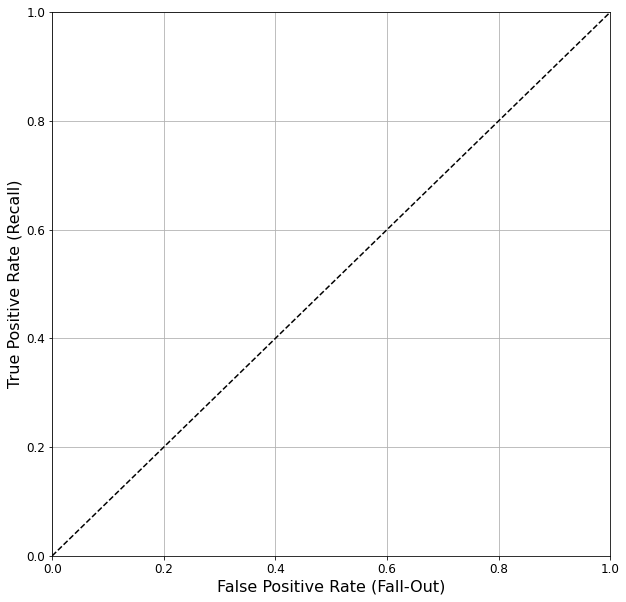

In [151]:
from sklearn.naive_bayes import GaussianNB
# model = MultinomialNB(alpha=0.0, class_prior=[0.4, 0.6])
# model.fit(X, Y)

X = bnb_data.select_dtypes(include=['float64'])
X = X.dropna(how='any',axis=0)
y = X["price"]
X = X.drop(columns=["price", "minimum stay cost per night", "long"])
x_trainTTS, x_testTTS, y_trainTTS, y_testTTS = train_test_split(X, y, test_size=0.5)
y_trainTTS_above_mean = (y_trainTTS > 626.110441)
y_testTTS_above_mean = (y_testTTS > 626.110441)

gnb = GaussianNB()
y_pred = gnb.fit(x_trainTTS, y_trainTTS_above_mean).predict(x_testTTS)
print("Number of mislabeled points out of a total %d points : %d accuracy %d" % (x_testTTS.shape[0], (y_testTTS_above_mean != y_pred).sum(), (((y_testTTS_above_mean != y_pred).sum())/(x_testTTS.shape[0])) * 100))

#alpha = (y_testTTS_above_mean != y.pred).sum()
#beta = x_testTTS.shape[0]
#print("Accuracy = ", (alpha / beta *100))

from sklearn.metrics import pair_confusion_matrix
confusion_matrix(y_testTTS_above_mean, y_pred)
matrix = confusion_matrix(y_testTTS_above_mean, y_pred)
print("TP = ", matrix[0][0])
print("FP = ", matrix[1][0])
print("TN = ", matrix[1][1])
print("FN = ", matrix[0][1])
print("Sensitivity = ", matrix[0][0]/(matrix[0][0] + matrix[0][1]))
print("specificity = ", matrix[1][1]/(matrix[1][1] + matrix [1][0]))
print("precision = ", matrix[0][0]/matrix[0][0] + matrix[1][0])
print("recall = ", matrix[0][0]/(matrix[0][0] + matrix [0][1]))
print("RoC Area = ")

plt.figure(figsize=(10,10))
plot_roc_curve((matrix[0][0]/(matrix[0][0] + matrix[0][1])), (matrix[0][0]/matrix[0][0] +matrix[1][0]))
plt.show


Bernoulli Naive Bayes
Number of mislabeled points out of a total 49034 points : 24618
Accuracy =  50.20597952441164
TP =  0
FP =  0
TN =  24416
FN =  24618
Sensitivity =  0.0
specificity =  1.0
precision =  nan
recall =  0.0
RoC Area = 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in long_scalars


<function matplotlib.pyplot.show(*args, **kw)>

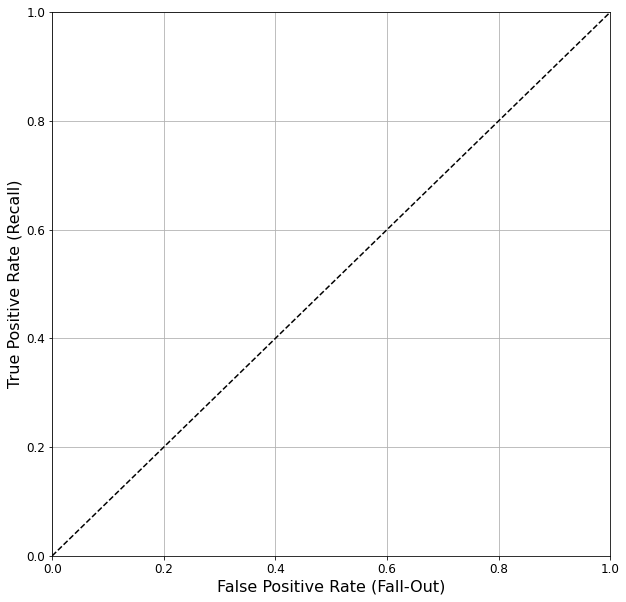

In [152]:
from sklearn.naive_bayes import BernoulliNB
# model = MultinomialNB(alpha=0.0, class_prior=[0.4, 0.6])
# model.fit(X, Y)

X = bnb_data.select_dtypes(include=['float64'])
X = X.dropna(how='any',axis=0)
y = X["price"]
X = X.drop(columns=["price", "minimum stay cost per night", "long"])
x_trainTTS, x_testTTS, y_trainTTS, y_testTTS = train_test_split(X, y, test_size=0.5)
y_trainTTS_above_mean = (y_trainTTS > 626.110441)
y_testTTS_above_mean = (y_testTTS > 626.110441)


bernnb = BernoulliNB(alpha=1.0, binarize=0.0, fit_prior=True, class_prior=[0.4, 0.6])
y_pred = bernnb.fit(x_trainTTS, y_trainTTS_above_mean).predict(x_testTTS)
print("Bernoulli Naive Bayes")
print("Number of mislabeled points out of a total %d points : %d" % (x_testTTS.shape[0], (y_testTTS_above_mean != y_pred).sum()))
#alpha = (y_testTTS_above_mean != y.pred).sum()
#beta = x_testTTS.shape[0]
print("Accuracy = ", (((y_testTTS_above_mean != y_pred).sum())/(x_testTTS.shape[0])) * 100)

from sklearn.metrics import pair_confusion_matrix
confusion_matrix(y_testTTS_above_mean, y_pred)
matrix = confusion_matrix(y_testTTS_above_mean, y_pred)
print("TP = ", matrix[0][0])
print("FP = ", matrix[1][0])
print("TN = ", matrix[1][1])
print("FN = ", matrix[0][1])
print("Sensitivity = ", matrix[0][0]/(matrix[0][0] + matrix[0][1]))
print("specificity = ", matrix[1][1]/(matrix[1][1] + matrix [1][0]))
print("precision = ", matrix[0][0]/matrix[0][0] + matrix[1][0])
print("recall = ", matrix[0][0]/(matrix[0][0] + matrix [0][1]))
print("RoC Area = ")

plt.figure(figsize=(10,10))
plot_roc_curve((matrix[0][0]/(matrix[0][0] + matrix[0][1])), (matrix[0][0]/matrix[0][0] +matrix[1][0]))
plt.show

Bernoulli Naive Bayes
Number of mislabeled points out of a total 49034 points : 2366
Accuracy=  95.17477668556512
TP =  22408
FP =  112
TN =  24260
FN =  2254
Sensitivity =  0.9086043305490228
specificity =  0.9954045626128344
precision =  113.0
recall =  0.9086043305490228
RoC Area = 


<function matplotlib.pyplot.show(*args, **kw)>

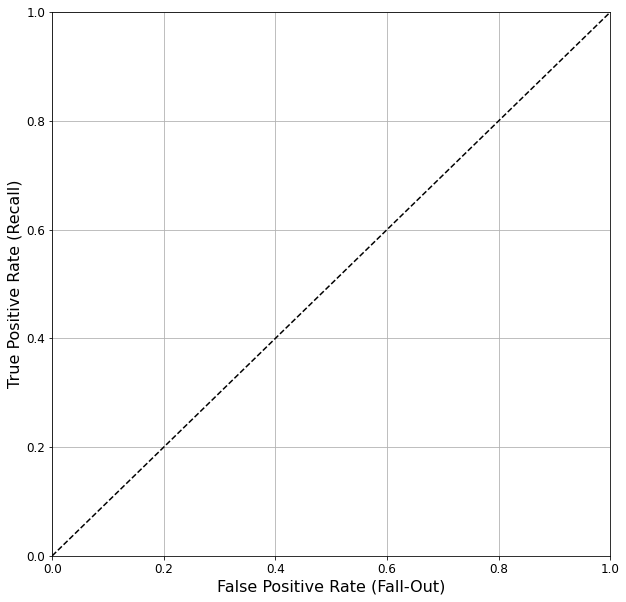

In [153]:
X = bnb_data.select_dtypes(include=['float64'])
X = X.dropna(how='any',axis=0)
y = X["price"]
X = X.drop(columns=["price", "minimum stay cost per night", "long"])

x_trainTTS.describe()

x_trainTTS, x_testTTS, y_trainTTS, y_testTTS = train_test_split(X, y, test_size=0.5)

y_trainTTS_above_mean = (y_trainTTS > 626.110441)
y_testTTS_above_mean = (y_testTTS > 626.110441)


from sklearn.naive_bayes import ComplementNB
print("Bernoulli Naive Bayes")


cnb = ComplementNB(alpha=1.0, fit_prior=True, class_prior=[0.4, 0.6], norm=False)
y_pred = cnb.fit(x_trainTTS, y_trainTTS_above_mean).predict(x_testTTS)
print("Number of mislabeled points out of a total %d points : %d" % (x_testTTS.shape[0], (y_testTTS_above_mean != y_pred).sum()))

alpha = (y_testTTS_above_mean == y_pred).sum()
beta = x_testTTS.shape[0]
print("Accuracy= ", (alpha / beta * 100))


confusion_matrix(y_testTTS_above_mean, y_pred)
matrix = confusion_matrix(y_testTTS_above_mean, y_pred)
print("TP = ", matrix[0][0])
print("FP = ", matrix[1][0])
print("TN = ", matrix[1][1])
print("FN = ", matrix[0][1])
print("Sensitivity = ", matrix[0][0]/(matrix[0][0] + matrix[0][1]))
print("specificity = ", matrix[1][1]/(matrix[1][1] + matrix [1][0]))
print("precision = ", matrix[0][0]/matrix[0][0] + matrix[1][0])
print("recall = ", matrix[0][0]/(matrix[0][0] + matrix [0][1]))
print("RoC Area = ")

plt.figure(figsize=(10,10))
plot_roc_curve((matrix[0][0]/(matrix[0][0] + matrix[0][1])), (matrix[0][0]/matrix[0][0] +matrix[1][0]))
plt.show

(58840, 9) (58840,) (39227, 9)
Number of mislabeled points out of a total 39227 points : 115
Accuracy=  99.70683457822417
TP =  19646
FP =  75
TN =  19466
FN =  40
Sensitivity =  0.9979680991567611
specificity =  0.996161915971547
precision =  76.0
recall =  0.9979680991567611
RoC Area =  0.997065007564154


<function matplotlib.pyplot.show(*args, **kw)>

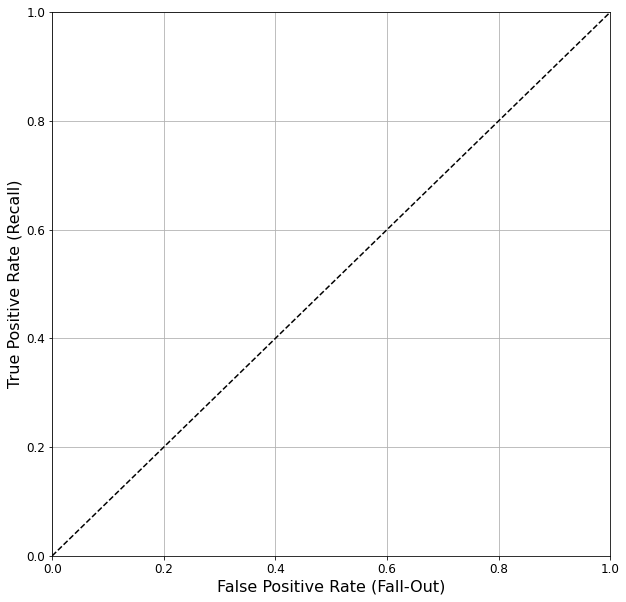

In [154]:
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import roc_auc_score

X = bnb_data.select_dtypes(include=['float64'])
X = X.dropna(how='any',axis=0)
y = X["price"]
X = X.drop(columns=["price", "minimum stay cost per night", "long"])
x_trainTTS, x_testTTS, y_trainTTS, y_testTTS = train_test_split(X, y, test_size=0.4)
y_trainTTS_above_mean = (y_trainTTS > 626.110441)
y_testTTS_above_mean = (y_testTTS > 626.110441)

clf = CategoricalNB(min_categories=2)
print(x_trainTTS.shape,y_trainTTS_above_mean.shape,x_testTTS.shape)
y_pred = clf.fit(x_trainTTS, y_trainTTS_above_mean).predict(x_testTTS)
print("Number of mislabeled points out of a total %d points : %d" % (x_testTTS.shape[0], (y_testTTS_above_mean != y_pred).sum()))

alpha = (y_testTTS_above_mean == y_pred).sum()
beta = x_testTTS.shape[0]
print("Accuracy= ", (alpha / beta * 100))

confusion_matrix(y_testTTS_above_mean, y_pred)
matrix = confusion_matrix(y_testTTS_above_mean, y_pred)
print("TP = ", matrix[0][0])
print("FP = ", matrix[1][0])
print("TN = ", matrix[1][1])
print("FN = ", matrix[0][1])
print("Sensitivity = ", matrix[0][0]/(matrix[0][0] + matrix[0][1]))
print("specificity = ", matrix[1][1]/(matrix[1][1] + matrix [1][0]))
print("precision = ", matrix[0][0]/matrix[0][0] + matrix[1][0])
print("recall = ", matrix[0][0]/(matrix[0][0] + matrix [0][1]))

roc_auc_score(y_testTTS_above_mean, y_pred)
print("RoC Area = ",roc_auc_score(y_testTTS_above_mean, y_pred))

plt.figure(figsize=(10,10))
plot_roc_curve((matrix[0][0]/(matrix[0][0] + matrix[0][1])), (matrix[0][0]/matrix[0][0] +matrix[1][0]))
plt.show

Clustering


In [155]:
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [158]:
y = bnb_data["price"]
X = X.dropna(how='any',axis=0)
X = bnb_data[["long", "lat"]]
print(X.describe())

               long           lat
count  98519.000000  98519.000000
mean     -73.949330     40.727974
std        0.049888      0.055977
min      -74.249840     40.499790
25%      -73.982520     40.688690
50%      -73.954320     40.722160
75%      -73.931900     40.762680
max      -73.705220     40.916970


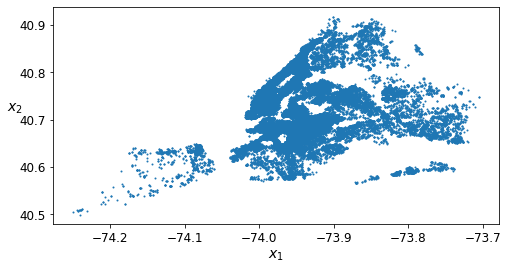

In [159]:
def plot_clusters(X, y=None):
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.show()

In [178]:
X = np.nan_to_num(X)


In [179]:
from sklearn.cluster import KMeans

k = 14
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

y_pred

array([10,  2,  4, ...,  9,  3,  2], dtype=int32)

In [180]:
y_pred is kmeans.labels_

kmeans.cluster_centers_

array([[-7.39186273e+01,  4.06866813e+01],
       [ 1.42108547e-14, -7.10542736e-15],
       [-7.39837508e+01,  4.07568224e+01],
       [-7.39664116e+01,  4.06780290e+01],
       [-7.39545472e+01,  4.07922514e+01],
       [-7.37744409e+01,  4.06588308e+01],
       [-7.39096483e+01,  4.07557460e+01],
       [-7.41027477e+01,  4.06117864e+01],
       [-7.39375032e+01,  4.08325600e+01],
       [-7.39510674e+01,  4.07147930e+01],
       [-7.39720661e+01,  4.06310210e+01],
       [-7.38280301e+01,  4.07323956e+01],
       [-7.39943930e+01,  4.07229223e+01],
       [-7.38659271e+01,  4.08618387e+01]])

In [181]:
kmeans.labels_

# X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
X_new = np.random.randn(5, 2) * 10
kmeans.predict(X_new)

array([1, 1, 1, 1, 1], dtype=int32)

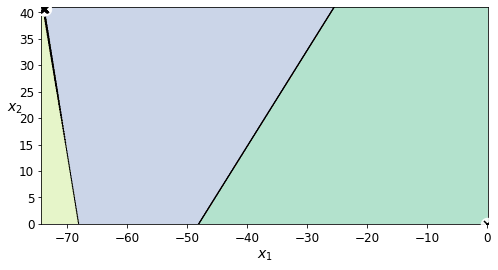

In [187]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
plt.show()